## Run LAS

In [1]:
#Build Molecule
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.npjunc import NPJunc

geom = NPJunc(dist=2.5,fn="logs/npjunc.log")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_(lroots=geom.lroots)
# las.ci = sign_control.fix_sign(las)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

# Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel(lroots=geom.lroots)
# civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds") #takes about 3 minutes on 16 cores

/home/king1305/Apps/pyscf/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


overwrite output file: logs/npjunc.log
Initiating LAS Model Space...
Done. Time elapsed: 130.18467815080658 seconds
Running LASSI...


WARN: Dumping only 100 of 113 spaces
WARN: To see more, explicitly pass nroots to dump_spaces or increase verbosity


Done. Time elapsed: 29.072486561955884 seconds


In [32]:
from pyscf.tools import molden
mos = las.mo_coeff[:,las.ncore:las.ncore+las.ncas]
molden.from_mo(las.mol,"../moldens/npjunc.molden",mos)

In [3]:
###Save Results w/ Pickle
import pickle

def dump_pkl(obj,fn):
    with open(fn,"wb+") as file:
        pickle.dump(obj,file)

results = {
    "energies_lassi":energies_lassi,
    "civecs_lassi":civecs_lassi,
    "n_frag":geom.n_frag,
    "p_frag":geom.p_frag,
    "ex_frag":geom.ex_frag,
    "las_charges":geom.las_charges,
    "nfrags":geom.nfrags,
}
dump_pkl(results,"logs/npjunc.pkl")

## Plotting

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/king1305/LAS_ET/periodiclas/tools/util.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]*8);


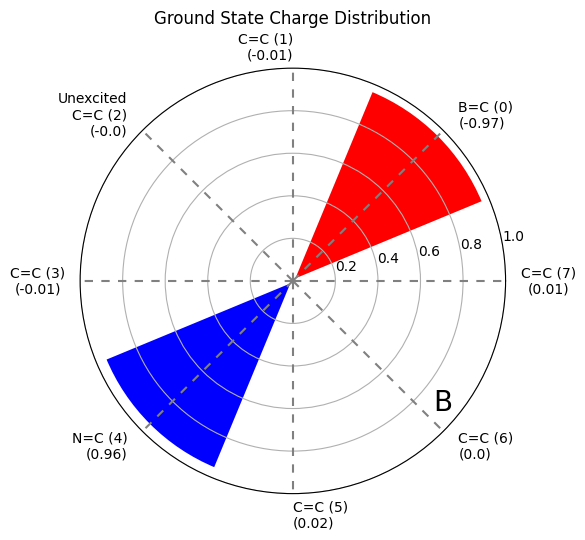

In [35]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import matplotlib.pyplot as plt
from tools.util import load_pkl, plot_charges

def calc_charges(results,state="gs"):
    assert(state in ["gs","exs"])
    civecs_lassi = results["civecs_lassi"]
    energies_lassi = results["energies_lassi"]
    class Obj:
        def __init__(self,results):
            self.n_frag = results["n_frag"]
            self.p_frag = results["p_frag"]
            self.ex_frag = results["ex_frag"]
            self.las_charges = results["las_charges"]
            self.nfrags = results["nfrags"]
    geom = Obj(results)
    
    from dsk.las.bandh import make_h
    H = make_h(civecs_lassi,energies_lassi,prnt=False)
    if state == "gs":
        states = [i for i in list(range(H.shape[0])) if i != 1] #exclude es
        H = H[np.ix_(states,states)]
    energies,civecs = np.linalg.eigh(H)

    p = civecs[:,0]**2
    charges = np.zeros(geom.nfrags)
    charges[geom.n_frag] = 1
    charges[geom.p_frag] = -1
    if state == "gs":
        p = civecs[:,0]**2
        charges = geom.las_charges + charges
    elif state == "exs":
        p = civecs[:,1]**2
        charges = np.vstack([geom.las_charges[0],geom.las_charges]) + charges
    charges = (charges * p[:,None]).sum(axis=0)
    labels = []
    for i in range(geom.nfrags):
        if i == geom.n_frag:
            labels += [f"{i} N=C ({i})"]
        elif i == geom.p_frag:
            labels += [f"{i} B=C ({i})"]
        elif i == geom.ex_frag:
            if state == "gs":
                labels += [f"{i} Unexcited\nC=C ({i})"]
            elif state == "exs":
                labels += [f"{i} Excited\n(C=C)* ({i})"]
        else:
            labels += [f"{i} C=C ({i})"]
    return charges,labels

results = load_pkl("logs/npjunc.pkl")
charges,labels = calc_charges(results,state="gs")
plot_charges(charges,labels)
plt.annotate("B",(-1.9*np.pi/8,0.9),fontsize=20)
plt.rcParams['axes.titley'] = 1.15
# plt.rcParams['axes.titlepad'] = -14 
plt.title("Ground State Charge Distribution")
plt.tight_layout()
plt.savefig("figures/unexcited_charge_dist.png",dpi=500)

/home/king1305/LAS_ET/periodiclas/tools/util.py:188: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]*8);


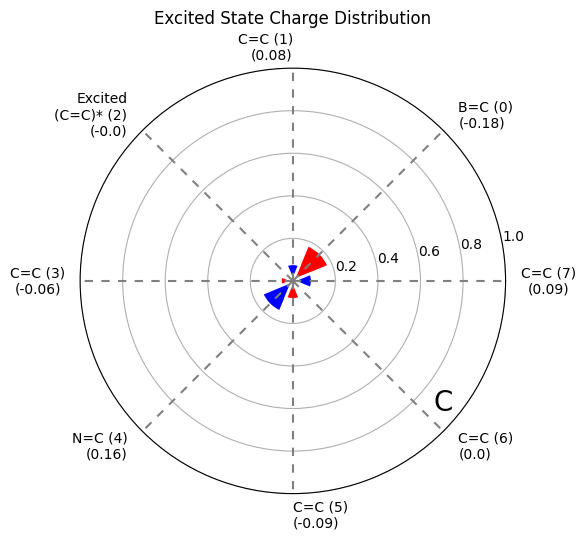

In [36]:
results = load_pkl("logs/npjunc.pkl")
charges,labels = calc_charges(results,state="exs")
plot_charges(charges,labels)
plt.annotate("C",(-1.9*np.pi/8,0.9),fontsize=20)
plt.title("Excited State Charge Distribution")
plt.tight_layout()
plt.savefig("figures/excited_charge_dist.png",dpi=500)

[-614.39 -613.94 -614.1  -614.1  -614.11 -614.11 -614.19 -614.19 -614.32
 -614.32 -614.14 -614.14 -614.08 -614.08 -614.06 -614.06 -613.79 -613.79
 -614.02 -614.02 -614.04 -614.04 -614.16 -614.16 -613.96 -613.96 -613.88
 -613.88 -613.81 -613.81 -613.62 -613.62 -613.86 -613.86 -614.04 -614.04
 -614.1  -614.1  -613.88 -613.88 -613.78 -613.78 -613.69 -613.69 -613.5
 -613.5  -613.67 -613.67 -613.85 -613.85 -614.08 -614.08 -613.81 -613.81
 -613.69 -613.69 -613.59 -613.59 -613.36 -613.36 -613.51 -613.51 -613.63
 -613.63 -613.81 -613.81 -613.76 -613.76 -613.59 -613.59 -613.46 -613.46
 -613.54 -613.54 -613.68 -613.68 -613.77 -613.77 -613.91 -613.91 -614.13
 -614.13 -613.85 -613.85 -613.67 -613.67 -613.66 -613.66 -613.78 -613.78
 -613.86 -613.86 -613.97 -613.97 -614.14 -614.14 -614.03 -614.03 -613.84
 -613.84 -613.84 -613.84 -613.9  -613.9  -613.96 -613.96 -614.05 -614.05
 -614.21 -614.21 -614.04 -614.04 -614.03 -614.03]


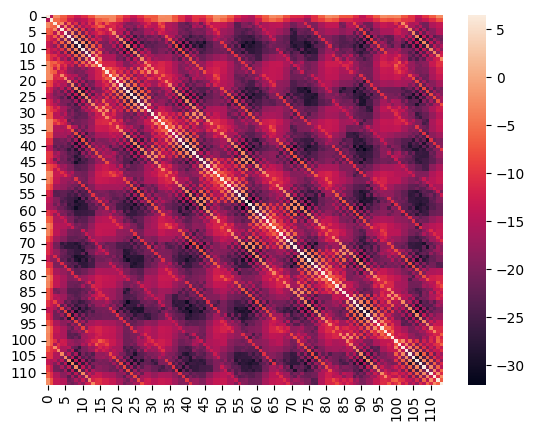

In [27]:
import pickle
import matplotlib.pyplot as plt

def load_pkl(fn):
    with open(fn,"rb") as file:
        return pickle.load(file)
        
from tools.bandh import make_h
import numpy as np
results = load_pkl("logs/npjunc.pkl")
H = make_h(results["civecs_lassi"],results["energies_lassi"],plot=False)
for i in range(H.shape[0]):
    H[i][np.where(H[i] != 0)] = np.log(np.abs(H[i][np.where(H[i] != 0)]))
    H[i][np.where(H[i] == 0)] = -20
import seaborn as sns
sns.heatmap(H)
plt.savefig("figures/npjunc_hamiltonian_log.png",dpi=500)

[-614.39 -613.94 -614.1  -614.1  -614.11 -614.11 -614.19 -614.19 -614.32
 -614.32 -614.14 -614.14 -614.08 -614.08 -614.06 -614.06 -613.79 -613.79
 -614.02 -614.02 -614.04 -614.04 -614.16 -614.16 -613.96 -613.96 -613.88
 -613.88 -613.81 -613.81 -613.62 -613.62 -613.86 -613.86 -614.04 -614.04
 -614.1  -614.1  -613.88 -613.88 -613.78 -613.78 -613.69 -613.69 -613.5
 -613.5  -613.67 -613.67 -613.85 -613.85 -614.08 -614.08 -613.81 -613.81
 -613.69 -613.69 -613.59 -613.59 -613.36 -613.36 -613.51 -613.51 -613.63
 -613.63 -613.81 -613.81 -613.76 -613.76 -613.59 -613.59 -613.46 -613.46
 -613.54 -613.54 -613.68 -613.68 -613.77 -613.77 -613.91 -613.91 -614.13
 -614.13 -613.85 -613.85 -613.67 -613.67 -613.66 -613.66 -613.78 -613.78
 -613.86 -613.86 -613.97 -613.97 -614.14 -614.14 -614.03 -614.03 -613.84
 -613.84 -613.84 -613.84 -613.9  -613.9  -613.96 -613.96 -614.05 -614.05
 -614.21 -614.21 -614.04 -614.04 -614.03 -614.03]


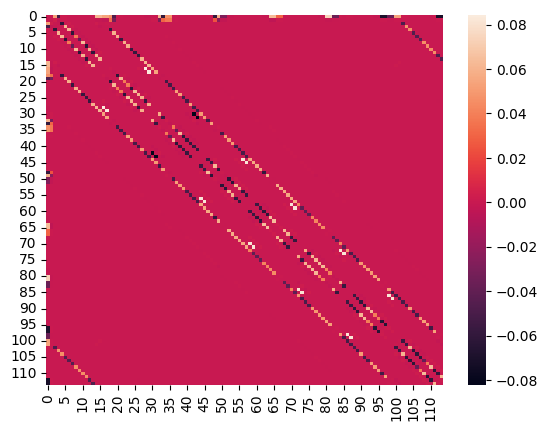

In [28]:
import pickle

def load_pkl(fn):
    with open(fn,"rb") as file:
        return pickle.load(file)
        
from tools.bandh import make_h
import numpy as np
results = load_pkl("logs/npjunc.pkl")
H = make_h(results["civecs_lassi"],results["energies_lassi"],plot=False)
H = H - np.diag(np.diag(H))
import seaborn as sns
sns.heatmap(H)
plt.savefig("figures/npjunc_hamiltonian_nodiag.png",dpi=500)